# Fine-Tuning Phi-4 for Machine Translation

This notebook fine-tunes the Phi-4 model for Machine Translation using the `stanfordnlp/sst2` dataset. It includes dataset downloading, preprocessing, fine-tuning with LoRA and Unsloth, and evaluation with Accuracy and training loss plotting.

## Setup
- **Environment**: Google Colab with T4 GPU (16GB VRAM).
- **Libraries**: Unsloth for efficient fine-tuning, Hugging Face Transformers, Datasets, and Evaluate for metrics.
- **Dataset**: `wmt/wmt14`.
- **Output**: Fine-tuned model, Accuracy plotting, and loss graph.




In [1]:
%%capture
!pip install evaluate
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

## 1. Load Model and tokennizer
Load the Phi-4 model with 4-bit quantization using Unsloth for memory efficiency.

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-4",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.9: Fast Llama patching. Transformers: 4.52.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## 2. Configure Model with LoRA adapter

Use LoRA for parameter-efficient fine-tuning.



In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None,
)

Unsloth 2025.5.9 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


## 3. Load and Preprocess Dataset

We load the `wmt/wmt14` dataset and preprocess it to extract classification tasks.




In [4]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-4",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"},
)

from datasets import load_dataset

wmt14_dataset = load_dataset('wmt14', 'fr-en')

def format_IWSLT_for_chat(examples):
    texts = []
    for translation_pair in examples['translation']:
        en_text = translation_pair['en']
        vi_text = translation_pair['fr']

        conversation = [
            {"from": "human", "value": f"Translate this English text to Vietnamese: {en_text}"},
            {"from": "gpt", "value": vi_text}
        ]

        text = tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=False)
        texts.append(text)

    return {"text": texts}

total_size = len(wmt14_dataset['train'])
sample_size = int(0.01 * total_size)
subset_dataset = wmt14_dataset['train'].select(range(sample_size))

formatted_dataset = subset_dataset.map(format_IWSLT_for_chat, batched=True)

print("Formatted sample:")
print(formatted_dataset[0]['text'])
print("\n" + "="*50 + "\n")
print(formatted_dataset[1]['text'])

train_size = int(0.9 * len(formatted_dataset))
train_dataset = formatted_dataset.select(range(train_size))
val_dataset = formatted_dataset.select(range(train_size, len(formatted_dataset)))

print(f"\nTotal original dataset size: {total_size}")
print(f"Using 1% subset size: {sample_size}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

train-00000-of-00030.parquet:   0%|          | 0.00/252M [00:00<?, ?B/s]

train-00001-of-00030.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00002-of-00030.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

train-00003-of-00030.parquet:   0%|          | 0.00/247M [00:00<?, ?B/s]

train-00004-of-00030.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

train-00005-of-00030.parquet:   0%|          | 0.00/238M [00:00<?, ?B/s]

train-00006-of-00030.parquet:   0%|          | 0.00/240M [00:00<?, ?B/s]

train-00007-of-00030.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00008-of-00030.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

train-00009-of-00030.parquet:   0%|          | 0.00/239M [00:00<?, ?B/s]

train-00010-of-00030.parquet:   0%|          | 0.00/239M [00:00<?, ?B/s]

train-00011-of-00030.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00012-of-00030.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00013-of-00030.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

train-00014-of-00030.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00015-of-00030.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

train-00016-of-00030.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

train-00017-of-00030.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

train-00018-of-00030.parquet:   0%|          | 0.00/261M [00:00<?, ?B/s]

train-00019-of-00030.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

train-00020-of-00030.parquet:   0%|          | 0.00/261M [00:00<?, ?B/s]

train-00021-of-00030.parquet:   0%|          | 0.00/264M [00:00<?, ?B/s]

train-00022-of-00030.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

train-00023-of-00030.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

train-00024-of-00030.parquet:   0%|          | 0.00/274M [00:00<?, ?B/s]

train-00025-of-00030.parquet:   0%|          | 0.00/278M [00:00<?, ?B/s]

train-00026-of-00030.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

train-00027-of-00030.parquet:   0%|          | 0.00/322M [00:00<?, ?B/s]

train-00028-of-00030.parquet:   0%|          | 0.00/370M [00:00<?, ?B/s]

train-00029-of-00030.parquet:   0%|          | 0.00/311M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/475k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/536k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40836715 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

Map:   0%|          | 0/408367 [00:00<?, ? examples/s]

Formatted sample:
<|im_start|>user<|im_sep|>Translate this English text to Vietnamese: Resumption of the session<|im_end|><|im_start|>assistant<|im_sep|>Reprise de la session<|im_end|>


<|im_start|>user<|im_sep|>Translate this English text to Vietnamese: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.<|im_end|><|im_start|>assistant<|im_sep|>Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez passé de bonnes vacances.<|im_end|>

Total original dataset size: 40836715
Using 1% subset size: 408367
Train dataset size: 367530
Validation dataset size: 40837


## 4. Setting Up Training Arguments and Fine-tune Model

Use SFTTrainer with Unsloth to fine-tune the model.

In [5]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import os

os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 4,
        warmup_steps = 2,
        max_steps = 50,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = [],
    ),
)

print("Set up trainer successful!")
print(f"training {50} steps with batch size {4}")

Unsloth: Tokenizing ["text"]:   0%|          | 0/367530 [00:00<?, ? examples/s]

Set up trainer successful!
training 50 steps with batch size 4


In [6]:
print("=== START TRAINING ===")
print(f"Dataset size: {len(train_dataset)}")
print(f"Batch size: 4")
print(f"Total steps: 50")
print("=" * 50)

trainer_stats = trainer.train()

print("\n=== END TRAINING ===")
print(f"Training loss: {trainer_stats.training_loss:.4f}")
print(f"Total training time: {trainer_stats.metrics.get('train_runtime', 'N/A')} seconds")

=== START TRAINING ===
Dataset size: 367530
Batch size: 4
Total steps: 50


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 367,530 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 65,536,000/4,000,000,000 (1.64% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,2.142400
10,1.460300
15,1.331400
20,1.490200
25,1.445400
30,1.390300
35,1.247700
40,1.350500
45,1.311400
50,1.410800



=== END TRAINING ===
Training loss: 1.4580
Total training time: 285.9745 seconds


## 6. Get Some Examples output

In [7]:
FastLanguageModel.for_inference(model)

test_sentences = [
    "Hello, how are you today?",
    "I love learning new languages.",
    "The weather is beautiful this morning."
]

for sentence in test_sentences:
    messages = [
        {"role": "user", "content": f"Translate this English text to France: {sentence}"}
    ]

    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True,
        return_tensors = "pt"
    ).to("cuda")

    outputs = model.generate(
        input_ids = inputs,
        max_new_tokens = 50,
        use_cache = True,
        temperature = 0.1,
        do_sample = True
    )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    print(f"English: {sentence}")
    print(f"France translation: {response.strip()}")
    print("-" * 50)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


English: Hello, how are you today?
France translation: Bonjour, comment allez-vous aujourd'hui ?
--------------------------------------------------
English: I love learning new languages.
France translation: J'adore apprendre de nouvelles langues.
--------------------------------------------------
English: The weather is beautiful this morning.
France translation: Il fait beau ce matin.
--------------------------------------------------


## 7. Evaluate The Model

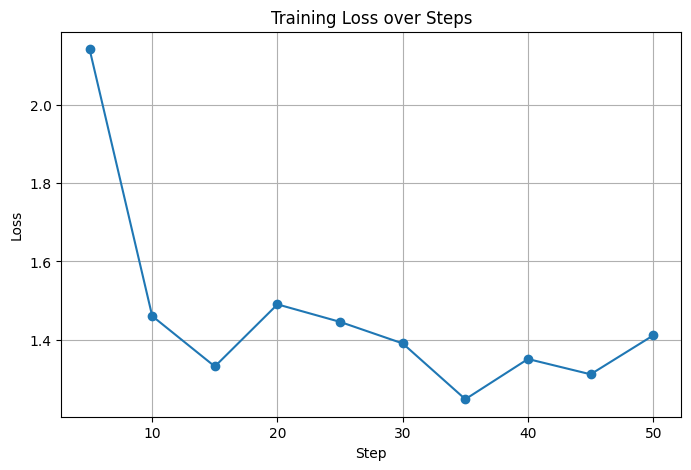

In [8]:
import matplotlib.pyplot as plt

loss_values = trainer.state.log_history

# Trích xuất step và loss
steps = [log['step'] for log in loss_values if 'loss' in log]
losses = [log['loss'] for log in loss_values if 'loss' in log]

# Plot
plt.figure(figsize=(8,5))
plt.plot(steps, losses, marker='o')
plt.title("Training Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [9]:
from evaluate import load
from tqdm import tqdm

meteor = load("meteor")
references = []
predictions = []

for item in tqdm(val_dataset[:50]["text"]):  # dùng 50 mẫu validation
    # Tách prompt để lấy input tiếng Anh
    input_prompt = item.split("Translate this English text to Vietnamese: ")[1].split("</s>")[0].strip()
    expected_output = item.split("gpt</s>")[-1].strip()

    messages = [{"role": "user", "content": f"Translate this English text to Vietnamese: {input_prompt}"}]
    inputs = tokenizer.apply_chat_template(messages, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=50,
        use_cache=True,
        temperature=0.1,
        do_sample=False
    )

    prediction = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True).strip()

    predictions.append(prediction)
    references.append(expected_output)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
100%|██████████| 50/50 [04:12<00:00,  5.06s/it]


In [10]:
meteor_score = meteor.compute(predictions=predictions, references=references)
print(f"\nMETEOR score on validation set (after fine-tuning): {meteor_score['meteor']:.4f}")


METEOR score on validation set (after fine-tuning): 0.2793


## 8. Login and Save Model to HuggingFace

In [11]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
The token `dailymail` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when

In [12]:
model.push_to_hub("thanhle1702/phii4-finetuned-wmt14")
tokenizer.push_to_hub("thanhle1702/phii4-finetuned-wmt14")

README.md:   0%|          | 0.00/584 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/262M [00:00<?, ?B/s]

Saved model to https://huggingface.co/thanhle1702/phii4-finetuned-wmt14


No files have been modified since last commit. Skipping to prevent empty commit.
